# Assignment 2

## Breifing

Overview. Peak detection or source finding is a generalised detection problem similar to anomaly detection, where spatial or temporal areas of interest need to be identified. Sources could resemble bright peaks amongst background noise or periods of high activity in time series data. In this assessment, a dataset of arbitrary origin is provided, which you will need to interpret. The dataset contains many sources with varying characteristics. Two datasets are provided, a frame-based dataset of 30 images and an event-based dataset of 10 event- streams. In the frame-based dataset, the number of sources varies, while the event-based dataset contains only one source per case. The aim of this assessment is to detect the sources using your own method, broadly classify/characterise the sources and evaluate your algorithm. The student is expected to develop reasonable solutions within the assessment time frame as an exploration of the trade-off between ‘perfect’ solutions which require copious resources and are beyond scope, compared to finished solutions delivered on time.

#### Q1. (40%) 
Develop an algorithm to detect the number of sources within the frame-based datasets, while attempting to maintain a low F1 score.
1. Overall algorithm design (25/40)
2. Overall performance/correctness (15/40)

#### Q2 
Build a simple classifier to characterise sources in the frame-based and event-based datasets. Characterisation should be used to place sources into several of your down source types based on the characteristics you deem potentially relevant.
1. Overall algorithm design. (10/30)
2. Estimation (with justification, there is room for interpretation) of the number of different source types and appropriate classification of sources into each type using the frame- based dataset. (10/30)
3. Extraction of characteristics from sources in the event-based datasets and rough characterisation based on these characteristics. (10/30)

#### Q3
Evaluate and briefly justify your algorithms
1. Justification of algorithm choice (5/30)
2. Complexity and scalability (5/30)
3. Compare your frame-based and event-based approach dataset (10/30)
4. Similarity to solutions within literature (5/30)
5. Profiling to identify bottlenecks (5/30)

In [1]:
import numpy as np
import cv2 as cv
from time import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm

## Image Based Processing

### Introduction

For this assignment I wanted to utilise and test many different methods of source detection and filtering. I developed a set of functions and visualisation tools which can be found in the imageDataProcessor.py python file. The set of code I will show illustrates the affects of each tool I tested and the intention behind its implementation.

In [2]:
import imageDataProcesser as imProcess

### Image Loader
The image loader method takes in a single value for the image number and grabs the image from the dataset in that position. To change images simply change the number from 0 to 29.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


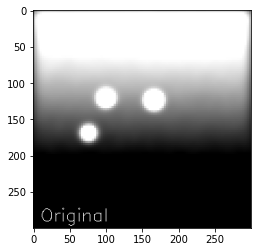

In [3]:
imageNo = 23
img, imgColour = imProcess.imageLoader(imageNo)

# Original Image
original = img
out = imProcess.normalize(original)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Original")
plt.imshow(out)

### Fourier Transform

I wanted to test the effects of the 2D fourier transform on the images. I found that after a fourier transform, it is possible to low-pass or high-pass the images easily which resulted in sources becoming much more distinct. The low-pass filter works by applying a circular mask to the image in the fourier domain. The size of the circular mask determines the effective image frequency that is lowpassed when the image is returned to the spatial domain.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


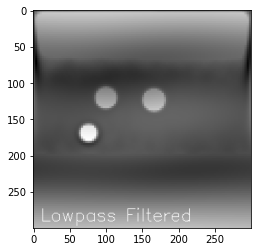

In [4]:
# Fourier Transform Lowpass
fourierTest = np.fft.fft2(img)
filtered, mask = imProcess.fourierFilter(fourierTest,lowpass=69, highpass=0, inv = False)
inverserFourierTest = np.fft.ifft2(filtered)
imageReconstruction = np.abs(inverserFourierTest)

out = imProcess.normalize(imageReconstruction)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Lowpass Filtered")
plt.imshow(out)

After filtering we can see the small source has become more distinct from the large source which is a helpful filter for source detection.

### Image Rescanning

Another step that can help the fourier transform is to rescan the image. What this means is to multiply the filtered image with the original. Doing this removed the noise generated in the fourier transform in the background while maintaining the important distinction between the sources.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


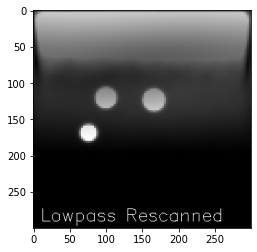

In [5]:
imageReconstruction = np.multiply(imageReconstruction, np.ones(np.shape(imageReconstruction), dtype=np.uint8))
rescannedImage = np.multiply(imageReconstruction, img)

out = imProcess.normalize(rescannedImage)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Lowpass Rescanned")
plt.imshow(out)

After rescanning we can see the small source is now the most apparent structure in the image.

### Edge detection

Convolution is another tool which I tested to help filter the images. I used Sobel edge detector kernels which generates strong edges where there are large changes in pixel intensity.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


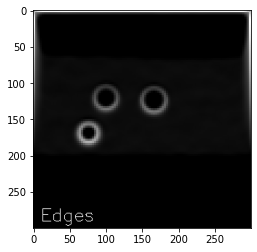

In [6]:
convolvedOriginal = imProcess.edgeDetector(img)

out = imProcess.normalize(convolvedOriginal)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Edges")
plt.imshow(out)

After a convolution on the original image we can see only small source is present in the image as a ring of it's edge.

### Convolution Continued

The convolution operator can be used after the fourier filter and rescanning to yield more distinct results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


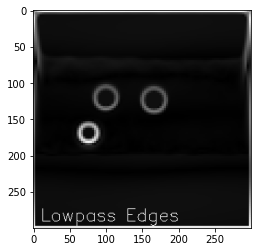

In [7]:
convolvedReconstruction = imProcess.edgeDetector(imageReconstruction)

out = imProcess.normalize(convolvedReconstruction)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Lowpass Edges")
plt.imshow(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


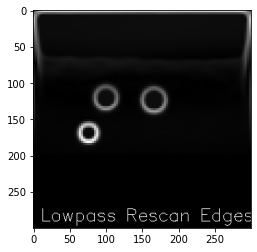

In [8]:
convolvedRescanImage = imProcess.edgeDetector(rescannedImage)

out = imProcess.normalize(convolvedRescanImage)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Lowpass Rescan Edges")
plt.imshow(out)

This image shows the image after being low-pass filtered, rescanned, then convolved. The source is quite distinct in this image.

### Hough Circles

The hough circle transform is where the source finding takes place. The circle transform looks to find circles in the image by mapping it to a 3 dimensional parameter space that returns the most prominent circle centres and radii. The transform is heavily dependent on initial parameters and can be prone to noise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


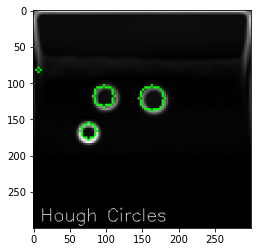

In [9]:
#Hough Circles
circlesOriginal, circleOriginalImage = imProcess.houghCircles(original, dp=1, minDist=8, param1=80, param2=5, minRadius=0, maxRadius=8)
circlesLP, circleLPImage = imProcess.houghCircles(imageReconstruction, dp=1, minDist=8, param1=80, param2=5, minRadius=0, maxRadius=8)
circlesRS, circleRSImage = imProcess.houghCircles(rescannedImage, dp=1, minDist=8, param1=80, param2=5, minRadius=0, maxRadius=8)
circlesConv, circleConvImage = imProcess.houghCircles(convolvedRescanImage, dp=1, minDist=8, param1=80, param2=5, minRadius=0, maxRadius=8)

out = imProcess.normalize(circleConvImage)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Hough Circles")
plt.imshow(out)

As the image shows the source is detected quite well but the hough circle transform picks up other things in the image that aren't sources.

NOTE: The text on the image is added in post.

### Super Pixel Segmentation

This tool I made segments the image into super pixels of similar pixel intensity. The algorithm works by looping through the pixels in the image and either creating a super pixel or attributing the pixel to an already existing super pixel. The algorithm has an intensity blur range and a neighborhood range. These two parameters affect how the pixels are clustered by the algorithm.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




33.13370728492737


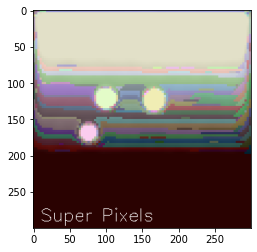

In [10]:
start = time()
# Super Pixel Generation
superPixelList, superPixelTest = imProcess.superpixelMapping(original, blur=12, checkRange=2)

out = imProcess.normalize(superPixelTest)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Super Pixels")
plt.imshow(out)
end = time()
print(end-start) 

Generating super pixels from the original image results in this colorful representation where each super pixel is represented by a different colour in the image. The super pixel is very good at picking up strong signals in the image which includes background and large sources.

### Hough Error Correction using super pixels.

Since super pixels are an incomplete form of classification, the super pixels can be used to determine the accuracy of hough circles. The overlap error of the hough circles and super pixels can determine whether a circle was the result of error or a source was detected.

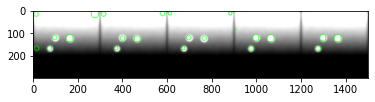

In [11]:
originalCircleImage = imProcess.makeCircles(original, circlesOriginal)
lowpassCircleImage = imProcess.makeCircles(original, circlesLP)
rescanCircleImage = imProcess.makeCircles(original, circlesRS)
convCircleImage = imProcess.makeCircles(original, circlesConv)

circleList, errorList = imProcess.houghSuperPixelErrorChecker(original, superPixelList, circlesConv, allowedError=0.4)
if circleList:
    newShape = np.reshape(circleList,(1,np.shape(circleList)[0],np.shape(circleList)[1]))
    errorCircleImage = imProcess.makeCircles(original, newShape)
else:
    errorCircleImage = imProcess.makeCircles(original, None)

out = np.hstack((originalCircleImage,lowpassCircleImage, rescanCircleImage, convCircleImage,errorCircleImage))
out = imProcess.normalize(out)
out = imProcess.convertTo3Channel(out)
out = imProcess.rescaleImage(out, 3)
out = imProcess.labelImages(out, "Hough Super Error")
plt.imshow(out)

On the left is the original hough circle detection on the lowpassed and rescanned image. In the middle is hough circles with an edge detector and lowpassed and rescanned, On the right is the super pixel corrected hough circles. These methods work well but can be prone to error for their own reasons.

In [12]:
labelledImg, unlabelledImg, superPixelList, labels = imProcess.superPixelClassifier(original, superPixelList, largeThreshold = 1000)

Found a large signal
Found Background


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


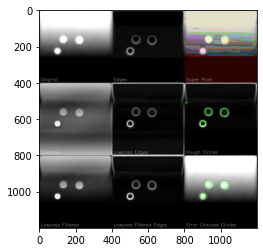

In [13]:
#Image Dictionary
imgs = {
    "Original":original, 
    "Lowpass":imageReconstruction, 
    "Lowpass Filtered":rescannedImage, 
    "Edges":convolvedOriginal, 
    "Lowpass Edges":convolvedReconstruction, 
    "Lowpass Filtered Edges":convolvedRescanImage,
    "Super Pixel":superPixelTest,
    "Hough Circles":circleConvImage,
    "Error Checked Circles": errorCircleImage,
}

# Image manipulation to make it clean to display
imgs = {key: imProcess.normalize(ims) for key, ims in imgs.items()}
imgs = {key: imProcess.convertTo3Channel(ims) for key, ims in imgs.items()}
imgs = {key: imProcess.rescaleImage(ims, 4) for key, ims in imgs.items()}
imgs = {key: imProcess.labelImages(ims, key) for key, ims in imgs.items()}

# Image output stacker optimised to fit a 16:9 display
imageOutput = imProcess.stackImages(list(imgs.values()), ratio=9/16)

plt.imshow(imageOutput)

### Results

#### Original Image Hough Transform F-Score

| Image Number | Actual | Time Taken | TP | FP  | FN |             |
|--------------|--------|------------|----|-----|----|-------------|
| 0            | 0      | 8.8        | 0  | 8   | 0  |             |
| 1            | 3      | 11         | 2  | 3   | 1  |             |
| 2            | 0      | 21.1       | 0  | 2   | 0  |             |
| 3            | 0      | 4          | 0  | 4   | 0  |             |
| 4            | 2      | 35.9       | 2  | 2   | 0  |             |
| 5            | 1      | 10.1       | 1  | 9   | 0  |             |
| 6            | 1      | 21.2       | 1  | 4   | 0  |             |
| 7            | 0      | 15.2       | 0  | 4   | 0  |             |
| 8            | 0      | 24.1       | 0  | 4   | 0  |             |
| 9            | 3      | 13.3       | 3  | 0   | 0  |             |
| 10           | 0      | 9.3        | 0  | 2   | 0  |             |
| 11           | 0      | 3.3        | 0  | 0   | 0  |             |
| 12           | 0      | 3.2        | 0  | 0   | 0  |             |
| 13           | 0      | 22.3       | 0  | 1   | 0  |             |
| 14           | 3      | 8.9        | 3  | 2   | 0  |             |
| 15           | 0      | 20.5       | 0  | 1   | 0  |             |
| 16           | 1      | 5.2        | 1  | 0   | 0  |             |
| 17           | 0      | 9.7        | 0  | 2   | 0  |             |
| 18           | 0      | 4.1        | 0  | 3   | 0  |             |
| 19           | 1      | 4.5        | 0  | 0   | 1  |             |
| 20           | 1      | 30.5       | 1  | 2   | 0  |             |
| 21           | 0      | 11.9       | 0  | 1   | 0  |             |
| 22           | 3      | 33.2       | 3  | 2   | 0  |             |
| 23           | 3      | 30.9       | 3  | 3   | 0  |             |
| 24           | 0      | 3.1        | 0  | 0   | 0  |             |
| 25           | 3      | 3.1        | 0  | 0   | 3  |             |
| 26           | 0      | 22.9       | 0  | 55  | 0  |             |
| 27           | 0      | 11         | 0  | 25  | 0  |             |
| 28           | 0      | 13.1       | 0  | 2   | 0  |             |
| 29           | 2      | 7.3        | 1  | 2   | 1  | F-Score     |
| Totals       | 27     | 422.7      | 21 | 143 | 6  | 0.219895288 |

#### F-Score after Filtering and correcting

| Image Number | Actual | Time Taken | TP | FP | FN |             |
|--------------|--------|------------|----|----|----|-------------|
| 0            | 0      | 8.8        | 0  | 0  | 0  |             |
| 1            | 3      | 11         | 0  | 0  | 3  |             |
| 2            | 0      | 21.1       | 0  | 0  | 0  |             |
| 3            | 0      | 4          | 0  | 0  | 0  |             |
| 4            | 2      | 35.9       | 1  | 0  | 1  |             |
| 5            | 1      | 10.1       | 1  | 0  | 0  |             |
| 6            | 1      | 21.2       | 1  | 0  | 0  |             |
| 7            | 0      | 15.2       | 0  | 0  | 0  |             |
| 8            | 0      | 24.1       | 0  | 0  | 0  |             |
| 9            | 3      | 13.3       | 2  | 0  | 1  |             |
| 10           | 0      | 9.3        | 0  | 0  | 0  |             |
| 11           | 0      | 3.3        | 0  | 0  | 0  |             |
| 12           | 0      | 3.2        | 0  | 0  | 0  |             |
| 13           | 0      | 22.3       | 0  | 0  | 0  |             |
| 14           | 3      | 8.9        | 1  | 0  | 2  |             |
| 15           | 0      | 20.5       | 0  | 0  | 0  |             |
| 16           | 1      | 5.2        | 0  | 0  | 1  |             |
| 17           | 0      | 9.7        | 0  | 0  | 0  |             |
| 18           | 0      | 4.1        | 0  | 0  | 0  |             |
| 19           | 1      | 4.5        | 0  | 0  | 1  |             |
| 20           | 1      | 30.5       | 0  | 0  | 1  |             |
| 21           | 0      | 11.9       | 0  | 0  | 0  |             |
| 22           | 3      | 33.2       | 1  | 0  | 2  |             |
| 23           | 3      | 30.9       | 3  | 0  | 0  |             |
| 24           | 0      | 3.1        | 0  | 0  | 0  |             |
| 25           | 3      | 3.1        | 1  | 0  | 2  |             |
| 26           | 0      | 22.9       | 0  | 0  | 0  |             |
| 27           | 0      | 11         | 0  | 0  | 0  |             |
| 28           | 0      | 13.1       | 0  | 0  | 0  |             |
| 29           | 2      | 7.3        | 1  | 0  | 1  | F-Score     |
| Totals       | 27     | 422.7      | 12 | 0  | 15 | 0.615384615 |

### F-Score

The F-Score of the image based dataset was evaluated as the number of small point sources that were identified. This explicitly excludes large sources which take up most of the image as those can be picked up by standard thresholding. The F-Score was calculated for each stage of the algorithm. Shown above is the F-Score for hough circles on the original image and then the F-Score on the final output of the algorithm. As it can be seen the algorithm helps significantly in reducing the number of false positives but is too aggressive and causes the loss of true positives as a result. The F-Score would also be heavily dependent on the algorithm parameters and may not have the perfect settings for this specific task. 

### Performance

The Filtering, convolution and hough circle stages of the algorithm all perform well and would scale well to larger images. The implementation of super pixel segmentation is considerably slow and is the slowest component of the algorithm resulting in a total time taken to process all images being 422.7 seconds. Super pixels are unfortunately somewhat crucial to the hough circle transform error correction. For this algorithm to perform better, the super pixel implementation should be optimised.

## Event Based Processing

### Introduction

For Event processing I developed a set of tools found in eventDataProcessor.py which can help manipulate the event data and produce useful results. Different event datasets can be selected by changing the value of dataOpt between 0 and 9

In [14]:
import eventDataProcesser as evProcess

### Dataset Preparation

To prepare the dataset I developed a loader function which loads the event dataset as a structured numpy array which allows for fast access and grouping of data in the array.

In [15]:
# Initialise data and load into system
filename = "COMP6001-A2-Datasets\\Event-based Dataset\\student_1_spike_data.mat"
dataset = evProcess.dataloader(filename)

# Choose dataset to view
dataOpt = 1
activeSet = dataset[dataOpt]

# INDEX SHOULD START AT 0!
activeSet["x"] = activeSet["x"]-1
activeSet["y"] = activeSet["y"]-1

### 3D Representation

For processing event data, 3D representation is useful and provides a unique way to organise the data.

In [16]:
# Generate 3D point cloud representation
representation3D = evProcess.pointCloudRepresentation(activeSet)

### Fourier Filtering

The fourier transform can also be used for event data since the event data is made up of discrete finite sets of firing patterns. Each pixel of the event data represents a single neuron firing channel. Applying the fourier transform on all pixels allows us to transform the event data from the time domain into the frequency domain. In this state I can perform a low-pass operation on the data which will negate high frequency firing rates in the recording for each pixel.

In [17]:
# Compute the fourier transform across the time axis
fourier3D = np.fft.fft(representation3D, axis=2)
# Lowpass the fourier transform representation
filteredFourier = evProcess.lowpassFilter(fourier3D, cutoff = 8)
# Return the data to the time domain get the absolute value and round to whole integer
reconstructedData = np.round(np.abs(np.fft.ifft(filteredFourier, axis=2)))

The fourier transform is computed on the data in it's 3D representation. After the fourier transform and low-pass filter the data is transformed back to the time domain and then rounded to the nearest 1 or 0. The representation is then converted back to standard event representation.

In [18]:
# Generate Event Data List
filteredSet = evProcess.eventRepresentation(reconstructedData)

### Characterisation

The event data can now be characterised and separated into noise events and source events. This is done by taking the original data and removing the filtered data to return only the noise events.

In [19]:
# Get Noise Events out of point cloud representation
noise3D = representation3D
noise3D[filteredSet["x"], filteredSet["y"], filteredSet["t"]] = 0
noise = evProcess.eventRepresentation(noise3D)

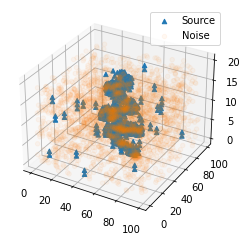

In [20]:
# Plot source and noise point clouds
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
labeled = ax.scatter(filteredSet["x"], filteredSet["y"], filteredSet["t"],marker='^',alpha=1)
noiseData = ax.scatter(noise["x"], noise["y"], noise["t"], marker='o',alpha=0.05)
ax.legend([labeled, noiseData], ['Source', 'Noise'])
plt.show()

The plot shows the 3D representation of the event data. the orange represents the noise events and the blue is the estimated source. As you can see the filter is not perfect but it produces a dataset that is more strongly correlated to specifically source events rather than noise events. The dataset can be further used to plot a path through the data.

In [21]:
centreList = []
for t in np.arange(filteredSet["t"].max()):
    slice = filteredSet[filteredSet["t"]==t]
    xCentre = np.mean(slice["x"])
    yCentre = np.mean(slice["y"])
    centreList.append((xCentre, yCentre, t))
centreData = np.asarray(centreList, dtype=evProcess.dtype)

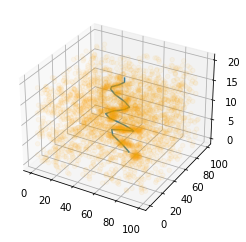

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
centre = ax.plot(centreData["x"], centreData["y"], centreData["t"])
noiseData = ax.scatter(noise["x"], noise["y"], noise["t"], color = "orange" ,marker='o',alpha=0.05)
plt.show()

By calculating the mean x value and y value for each time-step we can find the centre of the source data for each time-step and plot the position overtime. This mean value effectively characterises the movement of the source object in the event data.

### Evaluation

The fourier transform filter provides an adequate denoiser and simple classifier for the event data which scales well with larger arrays due to the fast fourier transform having a complexity of $O(Nlog(N))$. The filter could be improved by feeding this data into an unsupervised denoising autoencoder network which may be able to remove remaining noise in the data and restore some of the data that was lost in the fourier transform.